# WATPY - CoRe Database Tutorial

The watpy tool is still only Python2 compatible. Requires basic packages like *numpy* and *matplotlib* to function properly. Please install the package before trying this tutorial with

*sudo python setup.py install*

or

*python setup.py install --user*

if you do not have admin permissions.

## 0. Database Structure and Initialization

The CoRe Gravitational Wave Database is structured as follows:

* A public GitLab server (found at FUTURE_PUBLIC_IP ) contains the *core_database* group 
* Inside the public access group are stored single projects containing each simulation for which data is available. Each project is identified by its database key (see below).
* Together with the *data projects* is also a repository called *core_database_index* where information on the database entries is stored in the form of .json files.

Following this tutorial you should be able to syncronize the database correctly on your local machine. Note that generic users do not have write permissions on the database, so before trying to add new entries to the database please make sure to contact one of the database managers.

### 0.1 Database Index and Database Initialization

First of all, import the module containing the routines necessary for the database index operations

In [1]:
from db_utilities.index import *

It is now possible to initialize an *index object*, specifying the path where we would like the CoRe database to be initialized.

In [2]:
# This path can be an absolute or relative to the working directory
db_path = 'path/to/core_DB'

idb = CoRe_index(db_path)

Already up-to-date.



Initializing the *CoRe_index* object will clone the *core_database_index* in *db_path*, or syncronize it to the latest version in case the repository already exists.

It is now possible to syncronize the entire database via the *CoRe_index* object using the following:

In [ ]:
idb.sync_database()

Since the entire database is quite large, users might want to syncronize only the part of the database they intend to use. In this case, the *find(key, value)* routine of the *CoRe_index* object allows users to create a python dictionary of the simulations in the database that correspond to the indicated combination of *key* and *value* in their respective metadata dictionaries (of which the index is composed). Here we show the case of a user syncronizing only the simulations in the database whose Equation of State (EOS) is DD2.

In [4]:
# here dd2 is a python dictionary, whose keys are the database keys of the simulations
dd2 = idb.find('id_eos', 'DD2')

# Giving the sync_database the db_list argument explicitly we enforce the syncronization/cloning only of the 
# database entries whose keys are in the given list.
idb.sync_database(db_list=dd2.keys())

Already up-to-date.

Already up-to-date.

Already up-to-date.

Already up-to-date.

Already up-to-date.

Already up-to-date.

Already up-to-date.

Already up-to-date.



## 1. Database, Simulation and Run utilities

Once the database has been syncronized locally it is possible to use this tool to manage the database data and produce quick plots of its contents.

First of all, import the database utilities 

In [1]:
from db_utilities.dbutils import *

With the classes contained in the above module one only needs the path to where all the repositories containing data from the simulations from the CoRe GW database are situated.

First, one can recover the metadata for all available simulations with

In [2]:
cdb = CoRe_database(db_path)

Once the database object is created, it is possible to manipulate the list of simulations contained in it. This is important if one only wants to work on a subset of the entire database. The simplest manipulation is to select a subset of the database by selecting only runs that possess a certain value of a metadata keyord entry (e.g., EOS, ADM mass, ... )

In [3]:
db_subset = cdb.find('id_eos', 'SLy')

In [4]:
db_subset.keys()

['BAM:0128',
 'BAM:0121',
 'BAM:0120',
 'BAM:0123',
 'BAM:0122',
 'BAM:0125',
 'BAM:0124',
 'BAM:0127',
 'BAM:0126',
 'BAM:0103',
 'BAM:0102',
 'BAM:0101',
 'BAM:0100',
 'BAM:0107',
 'BAM:0106',
 'BAM:0105',
 'BAM:0104',
 'BAM:0109',
 'BAM:0108',
 'BAM:0095',
 'BAM:0097',
 'BAM:0096',
 'BAM:0099',
 'BAM:0098',
 'BAM:0110',
 'BAM:0111',
 'BAM:0112',
 'BAM:0113',
 'THC:0036',
 'BAM:0115',
 'BAM:0116',
 'BAM:0117',
 'BAM:0118',
 'BAM:0119',
 'BAM:0114']

*db_subset* is now a python dictionary where the keys are the simulations' *database_keys* and the values are *Core_Simulation* objects.

In [5]:
bam1 = cdb.sims['BAM:0001']

The *CoRe_simulation* object contains all information on the number of runs available for that set of initial data, as well as the required routines to extract the data from the HDF5 archive into readable text files that can be easily loaded into python for plots and/or further analysis.

In [6]:
print bam1.runs_id

r01 = bam1.runs['R01']

['R04', 'R01', 'R03', 'R02']


Once we select the desired run, we can extract data via the h5 sub-class. We can choose what to extract ($h$, $\Psi_4$ or the energetics of the waveform) or just extract everything in the same directory where the original HDF5 archive was stored. 

**PLEASE NOTE THAT THE EXTRACTED FILES ARE NOT TRACKED BY THE REPOSITORY, AND SHOULD NOT BE ADDED TO ANY COMMIT. ONLY THE HDF5 ARCHIVE SHOULD BE PUSHED TO THE REPOSITORY AFTER A SIGNIFICANT (AND APPROVED) CHANGE**

In [7]:
r01.h5.extract_all()

It is now possible to easily load the .txt files via usual python means (numpy.loadtxt or analogous modules). Another option is to use the *extract_h()* (or *extract_p4()*, *extract_ej()* for the other data) with the "return" keyword set to "True"

In [8]:
u, h = r01.h5.extract_h(return_h=True)

In this case we return the time as the tortoise coordinate $u$ and the complex-valued strain $h$

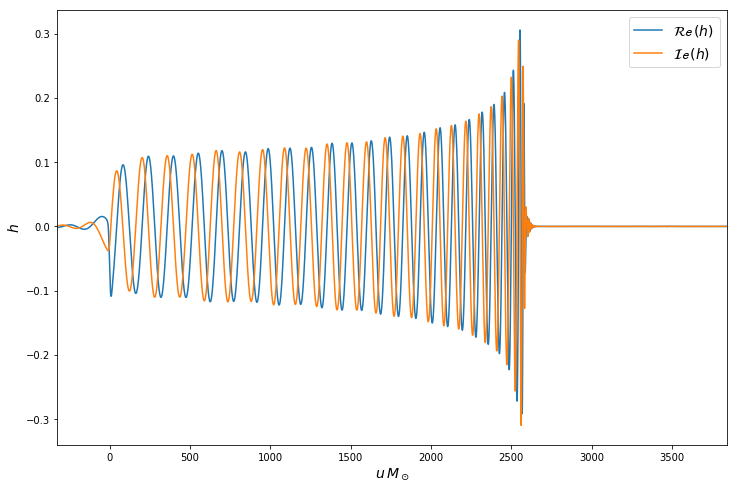

In [9]:
# Set appropriate size for legend entries
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rcParams.update(params)

# Set axis labels
plt.xlabel(r'$u\, M_\odot$', fontsize=14)
plt.ylabel(r'$h$', fontsize=14)

# Plot real and imaginary part of the strain
plt.plot(u,h.real, label=r'$\mathcal{Re}\, (h)$')
plt.plot(u,h.imag, label=r'$\mathcal{Ie}\, (h)$')

# Plot legend
plt.legend(ncol=1, loc='upper right')

# Fix range
plt.xlim([u.min(), u.max()]);

## 2. New database entry setup

*Classes from base/wave.py and db_utilities/db_utils.py*

Watpy contains routines to create appropriately formatted data for adding a new entry to the CoRe Database. At the moment both WhiskyTHC and BAM simulations can be processed automatically, after following a specific procedure (described below). Please make sure the data is indeed in the correct format, and that metadata files have been correctly compiled/updated before pushing changes to an existing repository (or creating a new repository if the model was not already present in the database).

The first steps are in common for both codes. 

* Setup new folder with the correct directory tree. You will be notified whether the new run has been added to an existing entry or if a new one has been created. The routine returns the *database_key* of the new/updated entry

In [5]:
new_dbkey = cdb.setup_new_run('BAM_fake_test_run', 'BAM')
rep_dbkey = cdb.setup_new_run('MS1b_1.375_1.375_0.11_0.00_0.0348_0.167', 'BAM')

Created new database entry BAM:0129.
Added run R03 to model BAM:0072.


 * In either case, we now need to fill the metadata appropriately. If a new entry has been created, a new *metadata_main.txt* and *metadata.txt* must be created. If the run has been added to an existing entry, the *available_resolutions* key of *metadata_main.txt* will be updated and a new *metadata.txt* for the new run will be created.

In [10]:
# First, we create a simulation object. Note that if the entry was already existing, we can take this from cdb.sims
new_sim = CoRe_simulation(new_dbkey.replace(':','_'))
rep_sim = CoRe_simulation(rep_dbkey.replace(':','_'))

# Now we must create the metadata for the last added run (for a new entry this is just R01)
# We can also look at which keys are required by calling mdu.keys
print mdu.keys

mdata_n = {}
mdata_r = {}

for key in mdu.keys:
    mdata_n[key] = None
    mdata_r[key] = None
#

# All keys should be filled, but at least simulation name one has to be added before creating the metadata
# This is due to how the database looks for existing simulations (see above)

mdata_n['simulation_name'] = 'BAM_fake_test_run'
mdata_r['simulation_name'] = 'MS1b_1.375_1.375_0.11_0.00_0.0348_0.167'

# Other information should be added now, but can in principle be also added later on by manipulating the dictionary

mdata_n['id_eos'] = 'DD2'
mdata_r['evolution_code'] = 'bam_14.07'

['database_key', 'simulation_name', 'available_resolutions', 'reference_bibkeys', 'id_code', 'id_type', 'id_mass', 'id_rest_mass', 'id_mass_ratio', 'id_ADM_mass', 'id_ADM_angularmomentum', 'id_gw_frequency_Hz', 'id_gw_frequency_Momega22', 'id_eos', 'id_kappa2T', 'id_Lambda', 'id_mass_starA', 'id_rest_mass_starA', 'id_spin_starA', 'id_LoveNum_kell_starA', 'id_Lambdaell_starA', 'id_mass_starB', 'id_rest_mass_starB', 'id_spin_starB', 'id_LoveNum_kell_starB', 'id_Lambdaell_starB', 'evolution_code', 'grid_refinement_levels', 'grid_refinement_levels_moving', 'grid_refinement_levels_npoints', 'grid_refinement_levels_moving_npoints', 'grid_spacing_min', 'grid_symmetries', 'grid_shells', 'grid_shells_radial_npoints', 'grid_shells_angular_npoints', 'grid_conservative_amr', 'metric_scheme', 'metric_boundary_conditions', 'hydro_flux', 'hydro_reconstruction', 'hydro_atmosphere_level', 'hydro_atmosphere_factor', 'number_of_orbits', 'evolution_mol_scheme', 'eos_evolution_Gamma_thermal']


* Now we split the cases: if the entry is a new one, we need to create a *metadata_main.txt* file in the database entry directory

In [17]:
md_s = new_sim.create_metadata(mdata_n)
md_r = new_sim.runs['R01'].create_metadata(mdata_n)

Working on database model...
No .h5 file found!
No .h5 file found!
No .h5 file found!
No .h5 file found!
Woking on database run...


* Otherwise, we just add the new resolution to the existing metadata by getting them again and updating

In [13]:
md = rep_sim.get_metadata()
# We add the new resolution run to the available_resolutions key
md['available_resolutions'] += ', R03'
rep_sim.update_metadata(md)

# Then we create the metadata for the new run
rep_sim.runs['R03'].create_metadata()


No .h5 file found!
No .h5 file found!
No .h5 file found!
Working on database model...


Now that we are set up, different codes have a slightly different procedure to follow

### 2.1 WhiskyTHC

First, we need to fefine the simulation source directory,  the run parameters and the correct regular expression for the files we want to collect


In [ ]:
# Path
simpath = 'PATH/TO/THC/SIMULATION'

# Run parameters (can be found in sim.mdata dictionary too)
m1      = 1.020
m2      = 1.856
m_adm   = 2.850
j_adm   = 7.406

# Regular expression
rf = r'mp_Psi4_l\d_m\d_r(\d+).00.asc'

Now we loop over all files in the first output directory to find which radii and which multipoles are available

In [ ]:
files = []

for f in os.listdir(simpath+'output-0000/data/'):
    if re.match(rf, f):
        files.append(f)
    #
#

Now we load the multipoles with the appropriate class and save $\Psi_4$, $h_{2,2}$ and the waveform energetics (not a WhickyTHC standard output!)

In [ ]:
mpls = mwaves(path=simpath, code='cactus', filenames=files, 
              mass=2.876, f0=576.*HZ_CU, ignore_negative_m=True)

for rad in mpls.radii:
    mpls.energetics(m1, m2, m_adm, j_adm, radius=rad, txt_out='yes')
    gw22 = mpls.get(l=2,m=2,r=rad)
    gw22.write_to_txt('Psi4')
    gw22.write_to_txt('h')
#

We can now proceed with the creation of the HDF5 archive using the CoRe simulation object we previously created.

In [ ]:
new_run = new_sim.runs['R01']
new_run.h5.create(path=new_run.path)

### BAM 

The procedure for BAM is very similar. The changes affect the regular expression for waveform output 

In [ ]:
rf_bam = r'(\w+)mode(\d)(m?)(\d)_r(\d+).l(\d+)'

And the path to walk to find the available multipoles and extraction radii

In [ ]:
files_bam = []

for f in os.listdir(os.path.join(simpath,'Scalars')):
    if re.match(rf_bam, f):
        files_bam.append(f)
    #
#

Now that the simulation data has been properly formatted one can proceed to check that everything works as intended and *git add / commit / push* the changes to the virtual machine holding the Core Database.

## 3. Waveform analysis tools

*Classes from base/wave.py*

Assuming we want to analyze the same run we loaded previously, if the data has been extracted already, we can use the *wave* module to load the single files

In [9]:
from base.wave import *

run = r01.mdata

ej =  wave(path=r01.path, code='core', filename='EJ_r00700.txt',
          mass=run['id_mass'], f0=float(run['id_gw_frequency_Hz'])*HZ_CU)

gw  = wave(path=r01.path, code='core', filename='Rh_l2_m2_r00700.txt',
          mass=run['id_mass'], f0=float(run['id_gw_frequency_Hz'])*HZ_CU)

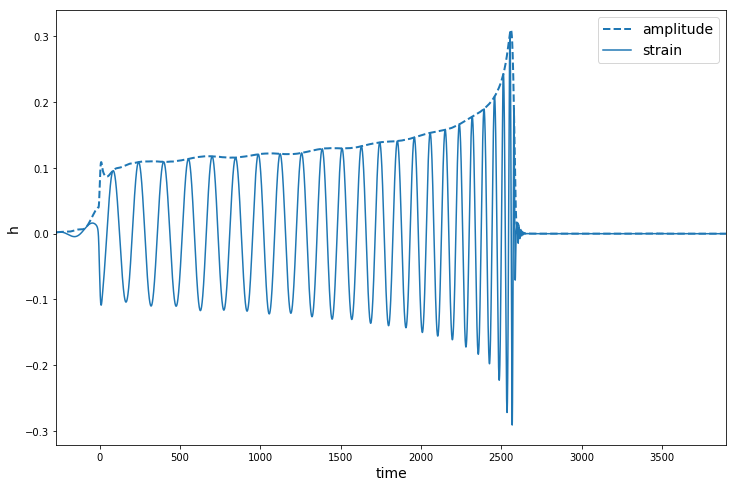

In [10]:
# Set appropriate size for legend entries
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rcParams.update(params)

u = gw.time
a = gw.amplitude('h')
h = gw.h

plt.plot(u, a, color='#1f77b4', linewidth=2, linestyle='--',
        label='amplitude')
plt.plot(u,h.real, color='#1f77b4', label='strain')
plt.xlabel('time', fontsize=14)
plt.ylabel('h', fontsize=14)
plt.legend(ncol=1, loc='upper right')
plt.xlim([u.min(), u.max()]);